### Prepare data for et0 caculate

In [ ]:
import pandas as pd
import glob

In [ ]:
def renamen_cloumns(data):
    data.columns = ['prec', 'tmin', 'tmax', 'netrad', 'uwind', 'vwind', 'date']
    return data

def caculate_wind(data):
    data['wind'] = (data['uwind']**2 + data['vwind']**2)**0.5  # Calculate wind speed
    return data 

def change_units(data):
    # Unit conversion and calculation
    data['netrad'] *= 1e-6  # Convert unit from J/m^2 to MJ/m^2
    data['prec'] *= 1000    # Convert unit from meters to millimeters
    return data 

In [ ]:
units_weather_files = glob.glob('../data/grid_units_weather/*.csv')
units_elevation = pd.read_csv('../data/grid_units/units_elevation.csv')

for id, file in enumerate(units_weather_files):
    data = pd.read_csv(file)
    data = renamen_cloumns(data)
    data = caculate_wind(data)
    data = change_units(data)
    
    # Filter required columns
    data = data[['prec', 'tmin', 'tmax', 'netrad', 'wind', 'date']]
    data['lat'] = units_elevation[units_elevation.ID == id]['lat'].iloc[0]
    data['ele'] = units_elevation[units_elevation.ID == id]['elevation'].iloc[0]

    filename = f'../data/grid_units_weather/prepare_data_for_et0/{id}.csv'
    data.to_csv(filename, index= False)

### Caculating et0

In [ ]:
import os
import pandas as pd
import glob
from aquacropeto import convert
from aquacropeto import fao

In [ ]:
def add_day_of_year(data):
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
    data['doy']=data['date'].dt.day_of_year
    return data

def cover_prec_samll_values(data):
    # Replace values in 'prec' column that are less than 1 with 0
    data['prec'] = data['prec'].apply(lambda x: 0 if x < 1 else x)
    return data
def change_kelvin2celsius(data):
    data['tmin'] = convert.kelvin2celsius(data.tmin)
    data['tmax'] = convert.kelvin2celsius(data.tmax)
    return data

def fao_et0(data):
    net_sw = fao.net_in_sol_rad(data.netrad)
    ext_rad = fao.et_rad(convert.deg2rad(data.lat), fao.sol_dec(data.doy),
                        fao.sunset_hour_angle(convert.deg2rad(data.lat),
                        fao.sol_dec(data.doy)),
                        fao.inv_rel_dist_earth_sun(data.doy))

    cl_sky_rad = fao.cs_rad(data.ele, ext_rad)
    net_lw_rad = fao.net_out_lw_rad(data.tmin, data.tmax, data.netrad, cl_sky_rad, fao.avp_from_tmin(data.tmin))
    net_radiation = fao.net_rad(net_sw, net_lw_rad)

    tmean = data.tmin*0.5+data.tmax*0.5
    ws = fao.wind_speed_2m(data.wind, 10)

    avp = fao.avp_from_tmin(data.tmin)
    svp = fao.mean_svp(data.tmin, data.tmax)
    delta = fao.delta_svp(tmean)

    psy = fao.psy_const_of_psychrometer(1, fao.atm_pressure(data.ele))

    faopm = fao.fao56_penman_monteith(net_radiation, convert.celsius2kelvin(tmean), ws, svp, avp, delta, psy)

    data["et0"] = faopm

    data.et0=data.et0.clip(0.1)

    # change time format
    data['Year'] = data['date'].dt.year
    data['Month'] = data['date'].dt.month
    data['Day'] = data['date'].dt.day
    data = data[["Day", "Month", "Year", "tmin", "tmax", "prec", "et0"]]
    # renames
    data.columns = ["Day", "Month", "Year", "Tmin(C)", "Tmax(C)", "Prcp(mm)", "Et0(mm)"]
    return data

def process_file(args):
    file, file_id, output_dir = args
    data = pd.read_csv(file)

    # Apply processing functions
    data = add_day_of_year(data)
    data = cover_prec_samll_values(data)
    data = change_kelvin2celsius(data)

    # caculate et0
    data = fao_et0(data)

    # Generate the output file path
    output_file = os.path.join(output_dir, f'{file_id}.csv')
    
    # Save the processed data to the output directory
    data.to_csv(output_file, index=False)

# Main function to iterate through all files with multiprocessing
def process_all_files(weather_files_path,  output_dir):
    # Get all CSV files
    units_weather_files = glob.glob(weather_files_path)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for id, file in enumerate(units_weather_files):
        process_file(args=[file, id, '../data/grid_units_aquacrop_weather/'])


In [ ]:
# units_weather_for_et0_files_paths = '../data/grid_units_weather/prepare_data_for_et0/*.csv'
# units_weather_for_et0_files = glob.glob(units_weather_for_et0_files_paths)
# for id, file in enumerate(units_weather_for_et0_files):
#     process_file(args=[file, id, '../data/grid_units_aquacrop_weather/'])

In [ ]:
weather_files_path = '../data/grid_units_weather/prepare_data_for_et0/*.csv'
output_dir = '../data/grid_units_aquacrop_weather/'
process_all_files(weather_files_path, output_dir)

### Extract soil data

In [ ]:
import pandas as pd
import ee


def authenticate_and_initialize_ee():
    """Authenticate and initialize Google Earth Engine (GEE)."""
    ee.Authenticate()
    ee.Initialize(project= "ee-xinjiangcotton")
    print("Authenticated and initialized Earth Engine.")


def read_point_data(data_path):
    """Read point data from a CSV file."""
    point_data = pd.read_csv(data_path)
    point_df = point_data.filter(items=['ID', 'lat', 'lon'])
    print("Point data loaded.")
    return point_df


def convert_dataframe_to_feature_collection(point):
    """Convert the pandas dataframe into a GEE Feature Collection."""
    features = []
    for _, row in point.iterrows():
        poi_geometry = ee.Geometry.Point([row['lon'], row['lat']])
        poi_properties = dict(row)
        poi_feature = ee.Feature(poi_geometry, poi_properties)
        features.append(poi_feature)

    ee_fc = ee.FeatureCollection(features)
    return ee_fc

def get_object_data(data_name):
    """Retrieve object data."""
    image = ee.Image(data_name)
    obj_data = ee.ImageCollection(image)
    print("Object data retrieved.")
    return obj_data


def extract_point_data(obj_data, ee_fc):
    """Extract data for each point location using the DEM dataset."""
    def rasterExtraction(image):
        feature = image.sampleRegions(
            collection=ee_fc,
            scale=10  # You can adjust the scale based on your requirements
        )
        return feature

    # Filter DEM data within the bounds of the points and extract elevation
    results = obj_data.filterBounds(ee_fc).map(rasterExtraction).flatten()
    return results

def convert_to_dataframe(results,obj_var,output_path):
    """Convert the results from GEE to a pandas DataFrame."""

    sample_result = results.first().getInfo()
    column_df = list(sample_result['properties'].keys())

    # Extracting nested list from results
    nested_list = results.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
    data = nested_list.getInfo()

    df = pd.DataFrame(data, columns=column_df)
    output_file = f'{output_path}/{obj_var}.csv'
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}.")


In [ ]:
# Example of how to use the class
data_path = '../data/grid_units/units.csv'
output_path = '../data/grid_units_aquacrop_soil'

object_varables = ['sand_mean', 'silt_mean', 'clay_mean', 'bdod_mean','soc_mean']

authenticate_and_initialize_ee()
point_df = read_point_data(data_path)
ee_fc = convert_dataframe_to_feature_collection(point_df)

for obj_var in object_varables:
    obj_data = get_object_data(f'projects/soilgrids-isric/{obj_var}')
    results = extract_point_data(obj_data, ee_fc)
    convert_to_dataframe(results, obj_var, output_path)

### preprocess soil data 

In [ ]:
import pandas as pd
from functools import reduce

def convert_wind(data, var):
    # Preprocess column names, remove 'mean'
    data.columns = [col.replace('_mean', '') for col in data.columns]

    # Convert using a wide to long method
    df_long = pd.wide_to_long(data, stubnames= var, i=['ID', 'lat', 'lon'], j='depth', sep='_', suffix='.+').reset_index()
    df_long.head()
    return df_long

def change_unit(df_long, var):
    if var == 'soc':
        # change dg/kg to % 
        df_long[var] = df_long[var] * 0.01

    if var == 'bdod':
        # change cg/cm3 to g/cm3
        df_long[var] = df_long[var] * 0.01

    # change g/kg to % 
    df_long[var] = df_long[var] * 0.1

    return df_long

def merge_soil_constitution(soil_files):
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['ID', 'lat', 'lon', 'depth'], how='outer'), soil_files)
    return merged_df

In [ ]:
soil_constitution = ['sand', 'silt', 'clay','soc','bdod']

soil_files =[]
for var in soil_constitution:
    file_path = f'../data/grid_units/{var}_mean.csv'
    data = pd.read_csv(file_path)
    df_long = convert_wind(data, var)
    df_long = change_unit(df_long, var)
    output_path = f'../data/grid_units_aquacrop_soil/{var}.csv'
    df_long.to_csv(output_path, index=False)
    soil_files.append(df_long)

merged_df = merge_soil_constitution(soil_files)
output_soil_file = merged_df[['ID','depth','sand','clay', 'silt', 'soc','bdod']]
output_soil_file.to_csv('../data/grid_units_aquacrop_soil/soil.csv', index=False)

# Calibrated testing

In [1]:
import os
os.environ['DEVELOPMENT'] = 'True'

In [2]:
import pandas as pd
weather_data = pd.read_csv('../data/calibration/weather.csv')
soil_data = pd.read_csv('../data/calibration/soil.csv')
irrigation_data = pd.read_csv('../data/calibration/irrigations.csv')
crop_pheno = pd.read_csv('../data/calibration/cotton_phenology.csv')
crop_parameters = pd.read_csv('../data/calibration/ini_crop_paramters.csv')


In [3]:
crop_pheno = crop_pheno[crop_pheno['ID']=='FKD']
crop_pheno = crop_pheno[(crop_pheno['samples']=='FKDFZ01AB0_01') | (crop_pheno['samples']=='FKDFZ01')]

crop_pheno.head()

,ID,years,samples,varities,planting,harvesting,emergence_dap,squaring_dap,flowering_dap,opening_dap,harvesting_dap
100,FKD,2006,FKDFZ01AB0_01,Xinshi_K4,04/25,11/15,7,53,85,122,204
101,FKD,2007,FKDFZ01AB0_01,Xinshi_K4,04/26,11/16,11,60,88,124,204
102,FKD,2008,FKDFZ01AB0_01,Xinshi_K4,04/27,11/15,10,48,76,124,202
103,FKD,2009,FKDFZ01AB0_01,Jan-83,04/22,11/10,11,54,81,136,202
104,FKD,2010,FKDFZ01AB0_01,Jan-83,04/30,11/10,12,47,70,129,194


In [4]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, FieldMngt, IrrigationManagement, GroundWater
from aquacrop.utils import prepare_weather, get_filepath

import pandas as pd

# from calibrated import crop_parameters
from calibrated import summary_results
# from calibrated import plots_cv_results
from calibrated import prepare_model_input_data as predata


def fit_model(id, year, var_param, sample, soil_data, weather_data, irrigation_data, crop_pheno):
    soil = predata.pre_soil(id, soil_data)
    
    weather = predata.pre_weather(id, weather_data)

    irrigation_management = predata.pre_irrigation_schedule(id, sample, irrigation_data)

    # initial water content
    initWC = InitialWaterContent(method='Depth', depth_layer=[1], value=['FC'])

    # filed_management
    filed_management = FieldMngt(mulches=True, mulch_pct=80, f_mulch=0.9)

    cotton, planting_date = predata.pre_crop_parameters(id, year, var_param, crop_pheno)

    model = AquaCropModel(
        sim_start_time=f'{int(year)}/{planting_date}',
        # sim_end_time=f'{year}/{harvest_date}',
        sim_end_time=f'{int(year)}/12/31',
        weather_df=weather,
        soil=soil,
        crop=cotton,
        initial_water_content=initWC,
        field_management=filed_management,
        irrigation_management=irrigation_management)
    return model

INFO:root:Running the simulation in development mode.
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.40.33807\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.40.33807\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.40.33807\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\shared" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\winrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\cppwinrt" /TcC:\Users\17702\AppData\Local\Temp\tmpjac60i8k\temp.c /FoC:\Users\17702\AppData\Local\Temp\tmpjac60i8k\temp.obj
INFO:root:"C:\

In [10]:

id = "FKD"
var = 'Jan-83'
year = '2015'
var_param = crop_parameters[crop_parameters['varities'] == var]
print(var_param)
sample = 'FKDFZ01AB0_01'
                           

model = fit_model(id, year, var_param, sample, soil_data, weather_data, irrigation_data, crop_pheno)
model.run_model(till_termination=True)

     ID varities  PlantPop    CGC    CDC  CCx  Zmin  Zmax  Kcb  WP  WPy  HI0  \
12  FKD   Jan-83    220000  0.092  0.061  0.9   0.2   1.4  1.1  15   75  0.3   

    PUP1  PLOW1  PUP2  PUP3  
12   0.2    0.7  0.75  0.75  


c:\Users\17702\anaconda3\envs\xinjiang_cotton\lib\site-packages\aquacrop\utils\prepare_weather.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df.ReferenceET.clip(lower=0.1, inplace=True)


IndexError: single positional indexer is out-of-bounds

In [8]:
for id in crop_pheno['ID'].unique():

    for var in crop_pheno[crop_pheno['ID'] == id]['varities'].unique():
        # update crop paraments 
        var_param = crop_parameters[crop_parameters['varities'] == 'var']
       
        for year in crop_pheno[(crop_pheno['ID'] == id) & (crop_pheno['varities'] == var)]['years'].unique():

            # for sample in crop_pheno[(crop_pheno['ID'] == id) & (crop_pheno['varities'] == var) & (crop_pheno['years'] == year)]['samples'].unique():
            sample = 'FKDFZ01AB0_01'
            # fit_model
            model = fit_model(id, year, var_param, sample, soil_data, weather_data, irrigation_data, crop_pheno)
            model.run_model(till_termination=True)
            summary_results.output_results(id, year, var, sample, model)

# save simulation results
summary_results.return_save_output_results(path="../results/calibration")

c:\Users\17702\anaconda3\envs\xinjiang_cotton\lib\site-packages\aquacrop\utils\prepare_weather.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df.ReferenceET.clip(lower=0.1, inplace=True)
c:\Users\17702\anaconda3\envs\xinjiang_cotton\lib\site-packages\aquacrop\entities\co2.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.co2_data = pd.read_csv(
c:\Users\17702\anaconda3\envs\xinjiang_cotton\lib\site-packages\a

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# for id in crop_pheno['ID'].unique():
#     for year in crop_pheno[crop_pheno['ID'] == id]['Years'].unique():
#         for sample in crop_pheno[(crop_pheno['ID'] == id) & (crop_pheno['Years'] == year)]['Sample'].unique():
#             # create_model
#             model = create_model(id, year, sample, soil_data, weather_data, irrigation_data, crop_pheno)
#             model.run_model(till_termination=True)
#             summary_results.output_results(id, year, sample, model)

### processing simulate soil water storage 

In [2]:
import pandas as pd 
data = pd.read_csv('../results/calibration/water_storage.csv')
data.head()

,time_step_counter,growing_season,dap,th1,th2,th3,th4,th5,th6,th7,th8,th9,th10,ID,years,samples,varieties,planting_date
0,0.0,1.0,1.0,0.201864,0.213717,0.167406,0.167406,0.163319,0.163319,0.240083,0.236582,0.235904,0.231528,FKD,2005,FKDZH01ABC_01,Xinshi_K4,4/20
1,1.0,1.0,2.0,0.187200,0.211579,0.162610,0.162610,0.158576,0.158576,0.227298,0.226161,0.228154,0.227498,FKD,2005,FKDZH01ABC_01,Xinshi_K4,4/20
2,2.0,1.0,3.0,0.176347,0.211124,0.162070,0.162070,0.158064,0.158064,0.223106,0.222727,0.225460,0.225230,FKD,2005,FKDZH01ABC_01,Xinshi_K4,4/20
3,3.0,1.0,4.0,0.166235,0.211026,0.162008,0.162008,0.158007,0.158007,0.221707,0.221580,0.224515,0.224434,FKD,2005,FKDZH01ABC_01,Xinshi_K4,4/20
4,4.0,1.0,5.0,0.157040,0.211006,0.162001,0.162001,0.158001,0.158001,0.221238,0.221195,0.224181,0.224153,FKD,2005,FKDZH01ABC_01,Xinshi_K4,4/20


In [1]:
dic = {'aka':['a','b','c'],
       'baka':['d','e','f'],
       'caka':['g','h','i']
}

In [1]:
param_dict = {
        'canopy_cover': {
            'params': ['CGC', 'CDC', 'CCx'],
            'bounds': [(0.06, 0.15),  # CGC range
                       (0.02, 0.15),  # CDC range
                       (0.5, 1)]      # CCx range
        },
        'biomass': {
            'params': ['WP', 'WPy'],
            'bounds': [(10, 20),  # WP range
                       (5, 15)]   # WPy range
        }
        # Add other objectives here as needed
    }

In [ ]:
for k, v in param_dict.items():
    

<Axes: >

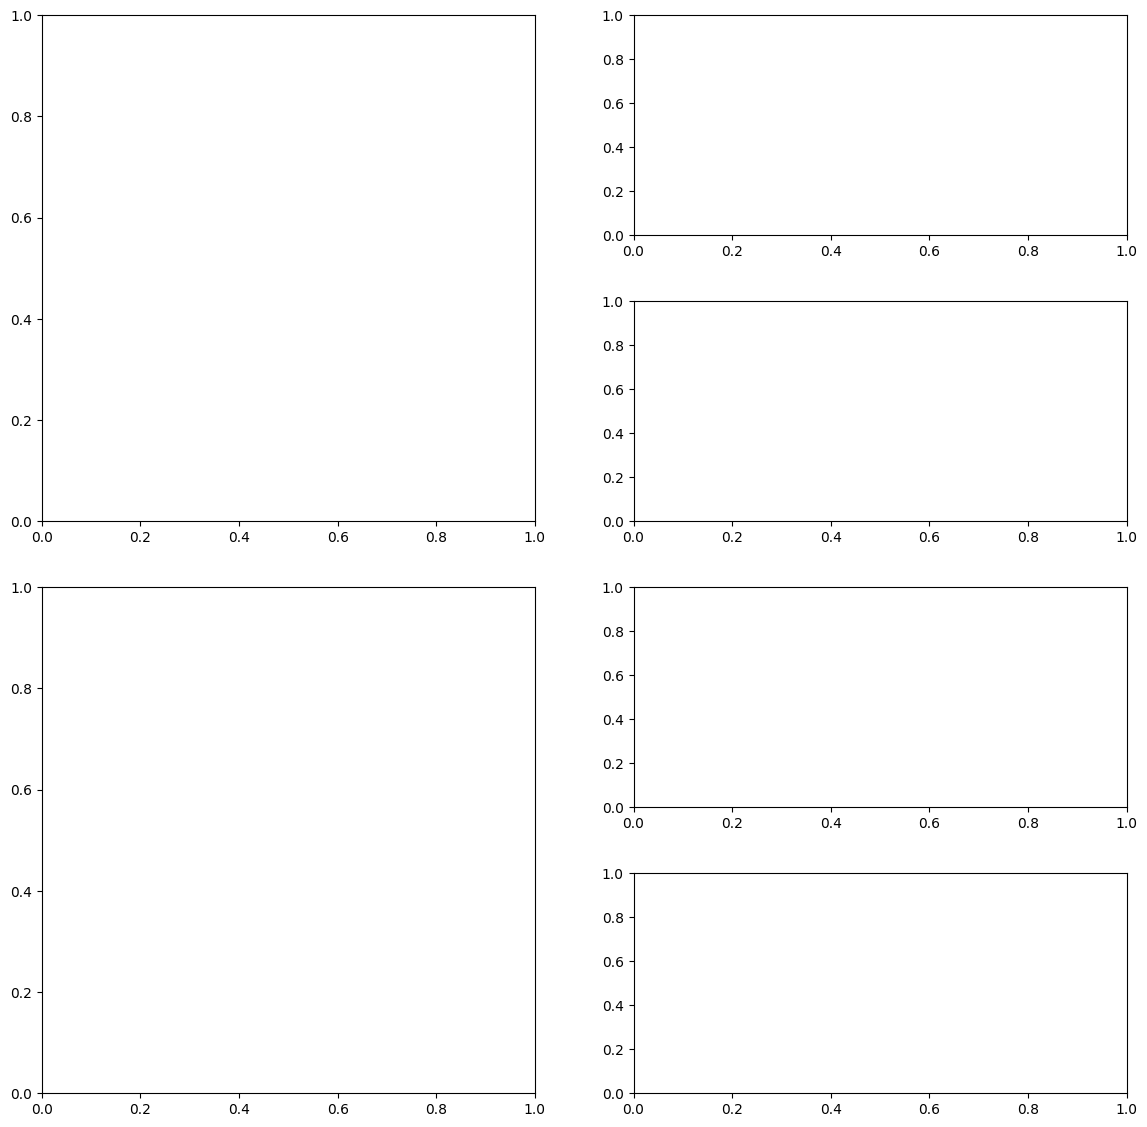

In [13]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(14, 14))
grid = plt.GridSpec(4, 2, wspace=0.2, hspace=0.3)
plt.subplot(grid[:2, 0])
plt.subplot(grid[2:, 0])
plt.subplot(grid[0, 1])
plt.subplot(grid[1, 1])
plt.subplot(grid[2, 1])
plt.subplot(grid[3, 1])